# Parameter Estimation for Ion Exchange and GAC Breakthrough Data

This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) and granular activated carbon (GAC) models. 

Both technologies are potential candidates for treated water impacted by per- and polyfluoroalkyl substances (PFAS). Critical to evaluating sorptive technologies for this purpose is accurate modeling of when the effluent concentration will hit a user (or regulation) defined limit, the "breakthrough concentration". The breakthrough time will dictate when the media is spent and either is regenerated or, like the case with PFAS, disposed, and will have significant implications for the cost of each process. In this demonstration, we will use publicly available data from an Orange County Water District (OCWD) report to obtain calibrated kinetic, mass transfer, and isotherm parameters.The data includes the time of breakthrough in bed volumes (BV) and the effluent concentration. We want to be able to have the model accurately predict the breakthrough time for a specific species and breakthrough concentration.

For this demonstration, we will use the Clark model for IX and the Constant Pattern Homogenous Surface Diffusion Model (CPHSDM) for GAC. Each model contains different parameters relevant to prediction of breakthrough time and is fully documented in the WaterTAP documentation.

<p align="center">
    <img src="images/report-cover.png" alt="Breakthrough Curve" width="400"/>
</p>

Figure 11 of the OCWD report presents the breakthrough data used in the pilot studies. In total, they evaluated eight different GAC media and four different IX resins.

Due to the lack of breakthrough for PFOS and PFHxS, we only consider the PFOA and PFBS data for the purposes of this demonstration. Of these four species, PFOA is the only one with a limit (10 ng/L).

<p align="center">
    <img src="images/breakthrough-curves.png" alt="Breakthrough Curve" width="800"/>
</p>

### Step 0: Imports

In [1]:
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import matplotlib.lines as mlines

from pyomo.util.calc_var_value import calculate_variable_from_constraint as cvc
import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.environ import (
    ConcreteModel,
    Objective,
    Expression,
    value,
    Var,
    Param,
    Constraint,
    ComponentUID,
    Suffix,
    assert_optimal_termination,
    check_optimal_termination,
    units as pyunits,
)

from idaes.core import (
    FlowsheetBlock,
    UnitModelCostingBlock,
)

import idaes.core.util.scaling as iscale

from idaes.core.util.model_statistics import degrees_of_freedom


from watertap.unit_models import (
    IonExchangeClark,
    GAC,
)
from watertap.core.solvers import get_solver
from watertap.costing import WaterTAPCosting
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.core.util.model_diagnostics.infeasible import *
from watertap.costing import WaterTAPCosting


solver = get_solver()

from collections import defaultdict

marker_dict = {
    "ect2_sorbix_lc4": "o",
    "calgon_calres_2301": "x",
    "a694e": "d",
    "evoqua_psr2+": "^",
    "calgon_f600": "o",
    "calgon_reactivated": "s",
    "cabot_norit": "D",
    "calgon_virgin": "^",
    "evoqua_ultracarb": "v",
    "cabot_hydrodarco": "<",
    "jacobi": ">",
    "evoqua_aquacarb": "x",
}
color_dict = {"PFOA": "green", "PFBS": "blue"}

with open("data/pfas_properties.yaml", "r") as f:
    pfas_properties = yaml.load(f, Loader=yaml.FullLoader)

with open("data/resin_properties.yaml", "r") as f:
    resin_properties = yaml.load(f, Loader=yaml.FullLoader)

with open("data/gac_properties.yaml", "r") as f:
    gac_properties = yaml.load(f, Loader=yaml.FullLoader)


def plot_curve(
    data,
    data2=None,
    x="filtered_x",
    y="filtered_y",
    yleg=None,
    set_dict=dict(),
    fig=None,
    ax=None,
):
    if yleg is None:
        yleg = y
    if data2 is None:
        data2 = data.copy()

    if (fig, ax) == (None, None):
        fig, ax = plt.subplots()
    ax.plot(
        data["all_bvs"],
        data["all_cnorms"],
        marker=".",
        label="All extracted data",
        color="k",
        alpha=0.25,
    )
    ax.scatter(
        data["keep_bvs"],
        data["keep_cnorms"],
        marker=".",
        label="Filtered data",
        color="blue",
    )
    ax.scatter(
        data["excl_bvs"],
        data["excl_cnorms"],
        marker="x",
        label="Excluded data",
        color="red",
    )
    ax.scatter(
        data2[x],
        data2[y],
        marker=".",
        label=yleg,
        color="green",
    )
    ax.plot(
        data2[x],
        data2[y],
        marker=None,
        # label=yleg,
        color="green",
        alpha=0.25,
    )
    ax.set_xlabel("Bed Volumes")
    ax.set_ylabel("C/C0")
    ax.set(**set_dict)
    ax.legend()
    ax.grid(zorder=0)
    return fig, ax

# Preparation

Using parmest requires the creation of an `Estimator` object that accepts a user-created list of `Experiment` objects. In order to create both of these things, there are a few things to prepare before we can do the parameter estimation:

* Cleaned data
* Objective function
* Initial guess
* Build function


# Data

In [2]:
ix_data = pd.read_csv("data/ix_ocwd_data.csv")
gac_data = pd.read_csv("data/gac_ocwd_data.csv")

<p align="center">
    <img src="images/ix_data_raw.png" alt="Breakthrough Curve" width="600"/>
</p>

<p align="center">
    <img src="images/gac_data_raw.png" alt="Breakthrough Curve" width="600"/>
</p>

# Filtering Data

Data filtering can be done any way, or the data can be provided any way. Filtering and smoothing the dataset can help parmest in converging on parameter values.

In this case, we are filtering the data such that the value is always below or above a certain threshold, and that the breakthrough concentration is generally increasing. Additionally, we ensure that no BV value is negative

Text(0.5, 1.0, 'Filtered GAC Data Example')

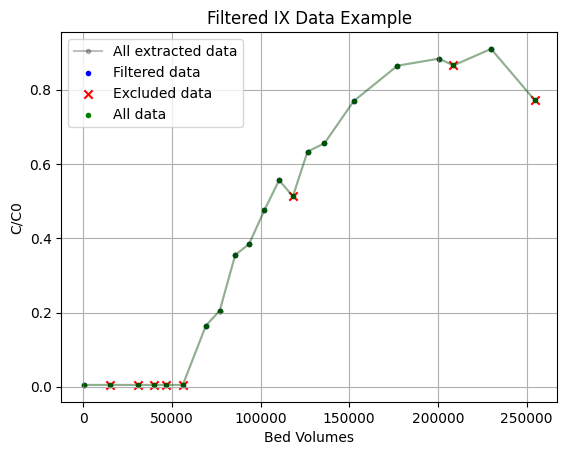

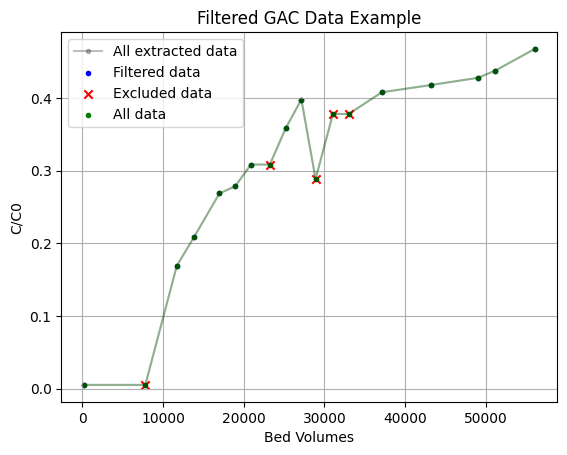

In [3]:
def filter_data(
    data,
    c0=None,
    bv_min=100,
    cnorm_min_thresh=0.005,
    cnorm_max_thresh=1.2,
):
    """
    Method to filter extracted breakthrough curve
    Loops through provided BVs and Cbs and keeps (bv, cb) pairs that meet all conditions:
    1. Current cb is greater than the last kept cb (last_cb)
    2. Current cb is greater than the minimum threshold
    3. Current cb is less than the maximum threshold
    4. Associated BV is not zero
    5. (if the current cb is not the last) The next cb (i + 1) is some threshold greater than the current cb
    """

    if c0 is None:
        c0 = data.c0.iloc[0]

    last_cb = -1e6
    d = defaultdict(list)

    data.loc[data["c_norm"] < cnorm_min_thresh, "c_norm"] = cnorm_min_thresh
    data["cb"] = data["c_norm"] * data["c0"]

    d["all_bvs"] = data.bv.to_list()
    d["all_cbs"] = data.cb.to_list()
    d["all_cnorms"] = data.c_norm.to_list()

    for i, cb in enumerate(data.cb):

        if cb == last_cb:
            d["excl_cbs"].append(cb)
            d["excl_bvs"].append(data.bv.iloc[i])
            # print(cb, "shsdf")
            continue

        if i != len(data.cb) - 1:
            if (
                cb >= last_cb
                and cb < c0
                and cb >= cnorm_min_thresh * c0
                and cb <= cnorm_max_thresh * c0
                and data.bv.iloc[i] > bv_min
            ):
                last_cb = cb
                d["keep_cbs"].append(cb)
                d["keep_bvs"].append(data.bv.iloc[i])
            else:
                d["excl_cbs"].append(cb)
                d["excl_bvs"].append(data.bv.iloc[i])
        else:
            if (
                cb >= last_cb
                and cb < c0
                # cb < c0
                and cb >= cnorm_min_thresh * c0
                and cb <= cnorm_max_thresh * c0
                and data.bv.iloc[i] >= bv_min
            ):
                last_cb = cb
                d["keep_cbs"].append(cb)
                d["keep_bvs"].append(data.bv.iloc[i])
            else:
                d["excl_cbs"].append(cb)
                d["excl_bvs"].append(data.bv.iloc[i])

    assert 0 not in d["keep_cbs"]

    d["keep_cnorms"] = [cb / c0 for cb in d["keep_cbs"] if not np.isnan(cb)]
    d["excl_cnorms"] = [cb / c0 for cb in d["excl_cbs"] if not np.isnan(cb)]

    d["filtered_y"] = d["keep_bvs"]
    d["filtered_x"] = [cb / c0 for cb in d["keep_cbs"]]

    filtered_data = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in d.items()]))
    filtered_data["c0"] = c0

    return filtered_data


curve = 1
curve_data = ix_data[ix_data["curve_id"] == curve].copy()

# Results of filtering IX data
ix_data_filtered = filter_data(curve_data)
fig, ax = plot_curve(ix_data_filtered, x="all_bvs", y="all_cnorms", yleg="All data")
ax.set_title("Filtered IX Data Example")

# Results of filtering GAC data
curve_data = gac_data[gac_data["curve_id"] == curve].copy()
gac_data_filtered = filter_data(curve_data)
fig, ax = plot_curve(gac_data_filtered, x="all_bvs", y="all_cnorms", yleg="All data")
ax.set_title("Filtered GAC Data Example")

# Model Build

A model build function must be developed in order to build the list of `Experiment` that are passed to the `Estimator` object. At a minimum, the build function must return the model. In addition, the build function *should* also:

1. Scale the model
2. Initialize the model
3. Solve the model

It is important that the model that is returned is stable because this it the model that will be used by parmest to do the parameter estimation routine. It is recommended that you test the stability of the model over a range of potential input conditions.

In [4]:
def build_ix_ocwd_pilot(
    species="PFOS", resin="calgon_calres_2301", theta_dict=dict(), **kwargs
):
    """
    Build for OCWD IX Pilot System
    """
    # PILOT SYSTEM INFO
    # FROM OCWD REPORT

    bed_depth = 29 * pyunits.inch
    flow_rate = 0.2 * pyunits.gallon / pyunits.minute
    ebct = 2.07 * pyunits.minute

    pfas_data = pfas_properties[species]
    resin_data = resin_properties[resin]

    ion_props = {
        "solute_list": [species],
        "mw_data": {
            "H2O": 0.018,
            species: pfas_data.get("mw", 0.350),
        },
        "molar_volume_data": {
            ("Liq", species): pfas_data.get("molar_volume", 0.0004),
        },
        "diffus_calculation": "HaydukLaudie",
        "charge": {species: -1},
    }

    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(**ion_props)
    ix_config = {
        "property_package": m.fs.properties,
        "target_component": species,
        "add_steady_state_approximation": False,
    }
    m.fs.unit = ix = IonExchangeClark(**ix_config)

    # Set pilot feed conditions
    pfas_mol_flow = (
        pfas_data["c0"]
        * pyunits.ng
        / pyunits.L
        / (pfas_data["mw"] * pyunits.kg / pyunits.mol)
        * flow_rate
    )
    h2o_mol_flow = 55.5 * pyunits.mol / pyunits.L * flow_rate
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].fix(h2o_mol_flow)
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].fix(
        pfas_mol_flow
    )
    ix.process_flow.properties_in[0].pressure.fix(101325)
    ix.process_flow.properties_in[0].temperature.fix(298)

    # Adjust bounds for pilot system
    ix.bed_depth.setlb(0)
    ix.bed_diameter.setlb(0)
    ix.ebct.setlb(0)
    ix.loading_rate.setlb(0)
    ix.loading_rate.setub(1)
    m.fs.unit.freundlich_n.setlb(1.05)
    m.fs.unit.freundlich_n.setub(100)
    m.fs.unit.bv.setlb(None)

    ix.resin_density.fix(resin_data["density"])
    ix.resin_diam.fix(resin_data["diameter"])
    ix.bed_depth.fix(bed_depth)
    ix.ebct.fix(ebct)
    ix.number_columns.fix(1)
    ix.c_norm.fix(0.5)

    for theta, val in theta_dict.items():
        ixv = m.find_component(theta)
        ixv.fix(val)

    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1 / value(h2o_mol_flow), index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1 / value(pfas_mol_flow), index=("Liq", species)
    )

    iscale.calculate_scaling_factors(m)

    assert degrees_of_freedom(m) == 0
    m.fs.unit.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    return m


curve = 1
curve_data = ix_data[ix_data["curve_id"] == curve].copy()
species, resin = curve_data.species.iloc[0], curve_data.resin.iloc[0]

initial_guess = {
    "fs.unit.bv_50": 120000,
    "fs.unit.mass_transfer_coeff": 0.2,
    "fs.unit.freundlich_n": 2.0,
}

m = build_ix_ocwd_pilot(species=species, resin=resin, theta_dict=initial_guess)

2025-08-31 20:23:50 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-08-31 20:23:50 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-08-31 20:23:50 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-08-31 20:23:50 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-08-31 20:23:50 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


# Creating a list of Experiments

Pyomo provides a template class `Experiment` to use to create the input list of experiments. Below is an inherited class for this application called `BreakthroughExperiment`. The class must include a `get_labeled_model` method that returns a model that:

* contains an `experiment_outputs` `Suffix` that contains the experimental data
* contains an `unknown_parmeters` `Suffix` that contains the parameters to be estimated
* has the variables (or, parameters) that are being estimated *unfixed*

Inputs for the `BreakthroughExperiment` class below are:

* `data`: the filtered experimental dataset
* `experiment_number`: a unique identifier for the experiment
* `initial_guess`: an initial guess for the thetas
* `build_function`: the model build function 
* `x_label`: name of the input variable. For these two models, this is the relative effluenct concentration (C/C0)
* `y_label`: name of the varible to be predicted. For these two models, this is the breakthrough time in BVs
* `build_kwargs`: dict any keyword arguments required for the build function
* `thetas`: list of strings of the parameters to be estimated

The `get_labeled_model` method proceeds as such:

1. build, scale, and initialize the model via the `build_function`
2. set the effluent concentration to be the experimental value
3. re-initialize and solve the model at the initial guess
4. unfix all the `theta` variables

In [5]:
class BreakthroughExperiment(Experiment):
    def __init__(
        self,
        data,
        experiment_number,
        initial_guess,
        build_function,
        build_kwargs,
        xlabel="",
        ylabel="",
        thetas=[],
    ):
        self.data = data
        self.experiment_number = experiment_number
        self.thetas = thetas
        self.initial_guess = initial_guess
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.build_function = build_function
        self.build_kwargs = build_kwargs

        self.data_exp = self.data.loc[experiment_number]

    def create_model(self):
        self.model = self.build_function(
            initial_guess=self.initial_guess, **self.build_kwargs
        )
        self.unit_blk = self.model.fs.unit

        return self.model

    def finalize_model(self):

        model = self.model

        xval = self.data_exp["x"].astype(float)
        yval = self.data_exp["y"].astype(float)

        xvar = self.model.find_component(self.xlabel)
        yvar = self.model.find_component(self.ylabel)

        xvar.fix(xval)
        yvar.set_value(yval)

        print(f"\ndof = {degrees_of_freedom(model)}")
        try:
            # sometimes it can take a few tries
            results = solver.solve(model)
            assert_optimal_termination(results)
        except:
            try:
                results = solver.solve(model)
                assert_optimal_termination(results)
            except:
                pass

        for theta in self.thetas:
            v = self.unit_blk.find_component(theta)
            if v is None:
                raise ValueError(
                    f"Could not find theta {theta} on {self.unit_blk.name}"
                )
            v.unfix()

        print(f"\ndof = {degrees_of_freedom(model)}")

        return self.model

    def label_model(self):

        xval = self.data_exp["x"].astype(float)
        yval = self.data_exp["y"].astype(float)
        xvar = self.model.find_component(self.xlabel)
        yvar = self.model.find_component(self.ylabel)

        self.model.experiment_outputs = Suffix(direction=Suffix.LOCAL)
        self.model.experiment_outputs.update(
            [
                (
                    xvar,
                    xval,
                ),
                (yvar, yval),
            ]
        )
        self.model.unknown_parameters = Suffix(direction=Suffix.LOCAL)
        self.model.unknown_parameters.update(
            [
                (k, ComponentUID(k))
                for k in [getattr(self.unit_blk, theta) for theta in self.thetas]
            ]
        )
        return self.model

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()

        return m

# Putting it all together

The following two classes `AdsorptionParamEst` put all these steps into one class.

Inputs for the `AdsorptionParamEst` class are:

* `data`: unfiltered DataFrame
* `build_function`: function that will return the model initialized and solved
* `filter_data_function`: function that will return filtered data
* `initial_guess`: dict of initial guess for thetas
* `x_label`: name of the input variable. For these two models, this is the relative effluenct concentration (C/C0)
* `y_label`: name of the varible to be predicted. For these two models, this is the breakthrough time in BVs
* `build_kwargs`: dict any keyword arguments required for the build function
*  `filter_data_kwargs`: dict of any keyword arguments required for the data filter function
* `parmest_kwargs`: dict of any keyword arguments to pass to parmest
 
With those inputs, the class can run a parameter estimation by calling the following methods in this order:

1. `filter_data`: filters the input breakthrough curve
2. `create_experiment_list`: creates a list of `BreakthroughExperiments` to pass to the `Estimator`
3. `run_parmest`: 

In [6]:
class AdsorptionParamEst:

    def __init__(
        self,
        data=None,
        build_function=None,
        obj_function=None,
        filter_data_function=None,
        initial_guess=dict(),
        thetas=list(),
        xlabel="",
        ylabel="",
        build_kwargs=dict(),
        filter_data_kwargs=dict(),
        parmest_kwargs=dict(),
    ):
        self.data = data
        self.build_function = build_function
        self.filter_data_function = filter_data_function
        self.obj_function = obj_function
        self.initial_guess = initial_guess

        self.thetas = thetas
        self.xlabel = xlabel
        self.ylabel = ylabel

        self.build_kwargs = build_kwargs
        self.filter_data_kwargs = filter_data_kwargs
        self.parmest_kwargs = parmest_kwargs

    def build_model(self):
        self.model = self.build_function(
            initial_guess=self.initial_guess, **self.build_kwargs
        )

    def filter_data(self):
        self.filtered_data = self.filter_data_function(
            self.data, **self.filter_data_kwargs
        )

    def create_experiment_list(self):
        if not hasattr(self, "filtered_data"):
            self.filter_data()

        self.experiment_list = []
        exp_dict = {
            "experiment_number": [
                x for x in range(len(self.filtered_data["filtered_x"].dropna()))
            ],
            "x": self.filtered_data["filtered_x"].dropna().values,
            "y": self.filtered_data["filtered_y"].dropna().values,
        }
        self.df_exp = pd.DataFrame.from_dict(exp_dict).set_index("experiment_number")

        for num in self.df_exp.index:
            self.experiment_list.append(
                BreakthroughExperiment(
                    self.df_exp,
                    num,
                    self.initial_guess,
                    self.build_function,
                    self.build_kwargs,
                    xlabel=self.xlabel,
                    ylabel=self.ylabel,
                    thetas=self.thetas,
                )
            )

    def run_parmest(self):

        if not hasattr(self, "experiment_list"):
            self.create_experiment_list()

        self.pestimator = parmest.Estimator(
            self.experiment_list, obj_function=self.obj_function, **self.parmest_kwargs
        )
        self.parmest_obj, self.parmest_theta = self.pestimator.theta_est()

        print("\nTHETA ESTIMATES:")
        for k, v in self.parmest_theta.items():
            n = k.split(".")[-1]
            if "e" in repr(v):
                print(f"  {n}: {v:.4e}")
            else:
                print(f"  {n}: {v:.4f}")

    def test_theta(self, xs=None, ys=None, theta_dict=None):

        if not hasattr(self, "parmest_theta"):
            self.run_parmest()

        if xs is None:
            xs = self.filtered_data["filtered_x"].dropna().values
        if ys is None:
            ys = self.filtered_data["filtered_y"].dropna().values
        if theta_dict is None:
            theta_dict = self.parmest_theta

        self.test_theta_results = defaultdict(list)
        self.build_kwargs["theta_dict"] = theta_dict

        for x, y in zip(xs, ys):
            self.build_model()
            xvar = self.model.find_component(self.xlabel)
            xvar.fix(x)
            results = solver.solve(self.model)
            assert degrees_of_freedom(self.model) == 0
            try:
                # self.model.fs.unit.initialize()
                results = solver.solve(self.model)
                assert_optimal_termination(results)
            except:
                try:
                    # self.model.fs.unit.initialize()
                    results = solver.solve(self.model)
                    assert_optimal_termination(results)
                except:
                    print(f"\n\nWarning: could not solve for x = {x}\n")
                continue

            yvar = self.model.find_component(self.ylabel)
            self.test_theta_results[self.xlabel].append(x)
            self.test_theta_results[self.ylabel].append(value(yvar))

        self.test_theta_results = pd.DataFrame.from_dict(self.test_theta_results)
        # self.test_theta_results["flag"] = "test_theta"


expr_sf = 1


def SSE(model):
    """
    Sum of squared error between `experiment_output` model and data values
    """
    expr = sum((y - y_hat) ** 2 for y, y_hat in model.experiment_outputs.items())
    return expr * expr_sf

In [8]:
curve = 1

df = ix_data[ix_data["curve_id"] == curve].copy()


initial_guess = {
    "fs.unit.bv_50": 120000,
    "fs.unit.mass_transfer_coeff": 0.2,
    "fs.unit.freundlich_n": 2.0,
}

build_kwargs = dict(
    species=species,
    resin=resin,
    theta_dict=initial_guess,
)

ix = AdsorptionParamEst(
    data=df,
    build_function=build_ix_ocwd_pilot,
    obj_function=SSE,
    initial_guess=initial_guess,
    filter_data_function=filter_data,
    xlabel="fs.unit.c_norm[PFOA]",
    ylabel="fs.unit.bv",
    thetas=["bv_50", "mass_transfer_coeff", "freundlich_n"],
    build_kwargs=build_kwargs,
)

ix.test_theta(theta_dict=initial_guess)
df_ig = ix.test_theta_results.copy()
ix.filter_data()
ix.create_experiment_list()
ix.run_parmest()
clear_output(wait=True)
ix.test_theta()
clear_output(wait=True)
df_theta = ix.test_theta_results.copy()

2025-08-31 20:24:25 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
2025-08-31 20:24:25 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-08-31 2

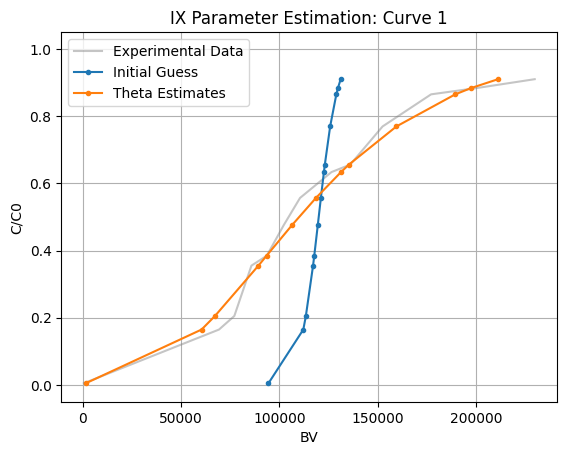

In [9]:
fig, ax = plt.subplots()

ax.plot(
    ix.filtered_data["filtered_y"],
    ix.filtered_data["filtered_x"],
    color="grey",
    marker=None,
    label="Experimental Data",
    alpha=0.45,
)
ax.plot(df_ig[ix.ylabel], df_ig[ix.xlabel], marker=".", label="Initial Guess")
ax.plot(df_theta[ix.ylabel], df_theta[ix.xlabel], marker=".", label="Theta Estimates")
ax.set_ylim([-0.05, 1.05])
ax.set(title="IX Parameter Estimation: Curve 1", xlabel="BV", ylabel="C/C0")
ax.grid(visible=True, zorder=0)
ax.legend()

In [10]:
ix_parmest_results = pd.read_csv(f"results/ix_parmest_results.csv")

<p align="center">
    <img src="images/ix_parmest_results.png" alt="Breakthrough Curve" width="800"/>
</p>

# Repeat for GAC